# Initial definitions and imports

In [2]:
import math
import numpy as np
import pandas as pd
import bagpipes as pipes
from astropy.table import Table, vstack, hstack
from astropy import units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from astropy.io import fits

mpl.rcParams['axes.labelsize']= 22
mpl.rcParams['legend.fontsize']= 15
mpl.rcParams['xtick.major.size']= 16
mpl.rcParams['xtick.minor.size']= 8
mpl.rcParams['ytick.major.size']= 16
mpl.rcParams['ytick.minor.size']= 8
mpl.rcParams['xtick.labelsize']= 16
mpl.rcParams['ytick.labelsize']= 16

filter_list_splus = ['filters/uJAVA.dat',
                     'filters/F0378.dat',
                     'filters/F0395.dat',
                     'filters/F0410.dat',
                     'filters/F0430.dat',
                     'filters/gSDSS.dat',
                     'filters/F0515.dat',
                     'filters/rSDSS.dat',
                     'filters/F0660.dat',
                     'filters/iSDSS.dat',
                     'filters/F0861.dat',
                     'filters/zSDSS.dat']


mags = ["u_aper_3", "J0378_aper_3", "J0395_aper_3", "J0410_aper_3", "J0430_aper_3", "g_aper_3", "J0515_aper_3", "r_aper_3",
        "J0660_aper_3", "i_aper_3", "J0861_aper_3", "z_aper_3"]
mags_err = ["e_u_aper_3", "e_J0378_aper_3", "e_J0395_aper_3", "e_J0410_aper_3", "e_J0430_aper_3", "e_g_aper_3",
            "e_J0515_aper_3","e_r_aper_3", "e_J0660_aper_3","e_i_aper_3", "e_J0861_aper_3", "e_z_aper_3"]

Bands=['u','J0378','J0395','J0410','J0430','g','J0515','r','J0660','i','J0861','z'] 
Bands_SDSS=['u','g','r','i','z'] 

cent_lambd={'u':3536,'J0378':3770,'J0395':3940,'J0410':4094,'J0430':4292, 'g':4751,
            'J0515':5133, 'r':6258, 'J0660':6614,   'i':7690 ,'J0861':8611, 'z':8831}
lamd=[3536,3770,3940,4094,4292,4751,5133,6258,6614,7690,8611,8831]

lamd_sdss=[3536,4751,6258,7690,8831]

# Tables

In [3]:
# spec=['spec-iDR4_3_STRIPE82-0073_0011797.fits','spec-iDR4_3_STRIPE82-0073_0039893.fits',
#       'spec-iDR4_3_STRIPE82-0065_0035625.fits','spec-iDR4_3_STRIPE82-0116_0005442.fits',
#       'spec-iDR4_3_STRIPE82-0074_0009433.fits', 'spec-iDR4_3_STRIPE82-0067_00111865.fits',
#       'spec-iDR4_3_STRIPE82-0067_0011186.fits','spec-iDR4_3_STRIPE82-0071_0009531.fits',
#       'spec-iDR4_3_STRIPE82-0071_0037955.fits','spec-iDR4_3_STRIPE82-0061_0019913.fits']

# 'spec-iDR4_3_STRIPE82-0067_00111865.fits' is not the correct one, should be 'spec-iDR4_3_STRIPE82-0072_0024325.fits'
## Reading the S-SPLUS table
tab_samp_SPLUS_aper_3=Table.read('/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/galaxies_splus_aper3_idr4_10sources.csv')
tab_samp_SPLUS_petro=Table.read('/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/galaxies_splus_petro_idr4_10sources.csv')
tab_samp_SDSS_model=Table.read('/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/galaxies_sdss_10sources_model.csv') 
tab_samp_SDSS_fiber=Table.read('/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/galaxies_sdss_10sources_fiber.csv') 
tab_samp_SDSS_fiber2=Table.read('/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/galaxies_sdss_10sources_fiber2.csv') 
spec = ['/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/SDSS Spectra/spec-' + tab_samp_SPLUS_aper_3[i]['ID'] + '.fits' for i in range(0,len(tab_samp_SPLUS_aper_3))]
df = Table.read('/mnt/h/Meu Drive/USP/Doutorado/BAGPIPES_Galaxies/galaxies_splus_aper3_idr4_10sources.csv')


# Functions

In [4]:
def load_data_splus(id):
        #print(id)
        # try:
        #     object, field = id.split('_')
        # except:
        #     object1, object2, field = id.split('_')
        #     object = object1 + '_' + object2

        fluxes = []
        fluxerrs = []
        galaxy_param = df[(df['ID'] == id)]
        
        # print(galaxy_param[mags])
        # print(galaxy_param[mags_err])

        for k in range(0, len(mags)):
            m = galaxy_param[mags[k]]
            #print(mags[k], galaxy_param[mags[k]])
            if (math.isnan(m)) | (m == np.inf) | (m == 99.) | (m == -99.):
                f = np.array([99.])
                delta_f = np.array([99.])
            else:
                f = 10**(9.56) * 10**(-m/2.5)  # flux in mJy
                delta_m = galaxy_param[mags_err[k]]
                delta_f = f * (1/2.5) * np.log(10) * delta_m


            fluxes.append(f)  #mJy
            fluxerrs.append(delta_f)  #mJy
        photometry = np.c_[fluxes, fluxerrs]
        return photometry

def flux_2_mJy (mag, mag_err):
    """
    This function convert magnitudes AB to microJy
    """
    fl = 10**9.56*10**(-mag/2.5) 
    fl_e = mag_err*fl/(2.5*np.log10(np.exp(1)))
    return fl, fl_e


def mJy_2_ergs_A(flux, band):
    """
    This fucntion convert flux in microJy to ergs/cm^2/s/A
    """
    fluxout = (flux*1e-6*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA,  equivalencies=u.spectral_density(cent_lambd[band] * u.AA))
    return fluxout

def convert(tab, Bands, num=0, data='S-PLUS_petro'):
    fl = []
    fl_err = []
    ID_num = num
    
    for band in Bands:
        if data=='S-PLUS_aper_3':
            mag = '{}_aper_3'.format(band)
            mag_e = 'e_{}_aper_3'.format(band)
        if data=='S-PLUS_petro':
            mag = '{}_petro'.format(band)
            mag_e = 'e_{}_petro'.format(band)
        if data=='SDSS':
            mag = '{}'.format(band)
            mag_e = 'err_{}'.format(band)
        
        fl_temp, fl_err_temp = flux_2_mJy(tab[ID_num][mag], 
                                        tab[ID_num][mag_e])
        fl.append(fl_temp)
        fl_err.append(fl_err_temp)

    fl_ergs_A = []
    fl_ergs_A_err = []
    ID_num = num
    for i, band in enumerate(Bands):
        
        fl_temp = mJy_2_ergs_A(fl[i], band)
        fl_temp_err = mJy_2_ergs_A(fl_err[i], band)
        
        fl_ergs_A.append(fl_temp.value)
        fl_ergs_A_err.append(fl_temp_err.value)
        
    fl_ergs_A = np.array(fl_ergs_A)
    fl_ergs_A_err = np.array(fl_ergs_A_err)  

    return fl_ergs_A, fl_ergs_A_err 

# BAGPIPES Run

In [5]:
# delayed = {}
# delayed["age"] = (0., 15.) # Time since SF began: Gyr
# delayed["tau"] = (0.3, 10.) # timescale of the decaying
# delayed["massformed"] = (1., 13.) # total stellar mass formed during this period of time
# delayed["metallicity"] = (0.01, 2.5) # Z/Z_solar = 0.02

# dblplaw = {}                         # double-power-law
# dblplaw["tau"] = (0.1, 15.) # Vary the time of peak star-formation between the Big Bang at 0 Gyr and 15 Gyr later.
#                             #In practice the code automatically stops this exceeding the age of the universe at the
#                             # observed redshift.
# dblplaw["alpha"] = (0.1, 1000.)          # Vary the falling power law slope from 0.01 to 1000.
# dblplaw["beta"] = (0.1, 1000.)           # Vary the rising power law slope from 0.01 to 1000.
# dblplaw["alpha_prior"] = "log_10"         # Impose a prior which is uniform in log_10 of the 
# dblplaw["beta_prior"] = "log_10"          # parameter between the limits which have been set above as 
#                                           # in Carnall et al. (2017).
# dblplaw["massformed"] = (1., 13.) # total stellar mass formed during this period of time
# dblplaw["metallicity"] = (0.01, 2.5) # Z/Z_solar = 0.02

exponential = {}
exponential["age"] = (0., 15.) # Time since SF began: Gyr
exponential["tau"] = (0.3, 10.) # timescale of the decaying
exponential["massformed"] = (1., 13.) # total stellar mass formed during this period of time
exponential["metallicity"] = (0.01, 2.5) # Z/Z_solar = 0.02

# burst = {}
# burst["age"] = (0., 15.) # Time since SF began: Gyr
# burst["massformed"] = (1., 13.) # total stellar mass formed during this period of time
# burst["metallicity"] = (0.01, 2.5) # Z/Z_solar = 0.02

dust = {}
dust["type"] = "Calzetti"
dust["Av"] = (0., 4.)
#dust["delta"] = (-0.3, 0.3)
#dust["delta_prior"] = "Gaussian"
#dust["delta_prior_mu"] = 0.
#dust["delta_prior_sigma"] = 0.1
#dust["B"] = (0.,5.)
#dust["eta"] = 3. #factor of birth clouds

nebular = {}
nebular["logU"] = (-4,-2)

model_components = {}
model_components["t_bc"] = 0.01           # Max age of birth clouds: Gyr
model_components["dust"] = dust
model_components["nebular"] = nebular
model_components["exponential"] = exponential
#model_components["burst"] = burst
#model_components["delayed"] = delayed
#model_components["dblplaw"] = dblplaw
#model_components["veldisp"] = (0.,100.)          # Velocity dispersion: km/s


IDs = df['ID']

redshifts = df['Z']
fit_cat = pipes.fit_catalogue(IDs, model_components, load_data_splus, spectrum_exists=False,
                              cat_filt_list=filter_list_splus, run="galaxies_aper3_idr4_delayed_10sources0", make_plots=True,
                              full_catalogue=True, redshifts=redshifts)
fit_cat.fit(verbose=False)

In [6]:
ID = df['ID'][0]

redshifts = df['Z']
galaxy = pipes.galaxy(ID, load_data_splus, spectrum_exists=False,
                            filt_list=filter_list_splus)
fit = pipes.fit(galaxy, model_components, run="galaxies_aper3_idr4_delayed_10sources0")
fit.fit(verbose=False)
fit.posterior.get_advanced_quantities()

phot_table = Table()
#print(phot_table)
photometry = Table(np.asarray([(np.percentile(fit.posterior.samples['photometry'][:, k], 50)) for k in range(0,12)]))
#phot_table = phot_table.append(photometry)
#print(phot_table)
#phot_table = phot_table.append(photometry)
##print(phot_table)

phot_table = vstack([phot_table, photometry])
print(phot_table)
#print(photometry*10)
# print(photometry.dtype)
# phot_table = np.array([])
# print(phot_table)
# print(len(phot_table))
# phot_table = np.append(phot_table, photometry)
# print(phot_table)
# print(len(phot_table))
# phot_table = np.append(phot_table, photometry)
# print(phot_table)
# print(len(phot_table))

#print(np.percentile(fit.posterior.samples['photometry'][0,:], 50))

max_like_index = np.argmax(fit.results["lnlike"])
#print(max_like_index)
#print(fit.results["samples2d"][max_like_index, :])

#print(len((fit.results["lnlike"])))
# plt.figure()
# stellar_mass=0
# for i in range(len((fit.results["lnlike"]))):
#     fit.fitted_model._update_model_components(fit.results["samples2d"][i, :])
#     model_components = fit.fitted_model.model_components
#     model_galaxy = pipes.model_galaxy(model_components, filt_list=filter_list_splus,
#                                            spec_wavs=np.arange(3000., 10000., 5.))

#     stellar_mass = stellar_mass + model_galaxy.sfh.stellar_mass
    #a = a + fit.results["lnlike"][i]*fit.results["samples2d"][i,2]/np.sum(fit.results["lnlike"])



#plt.figure()
# plt.plot()




Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0061_0019913.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0061_0019913.h5. To start over delete this file or change run.

         col0                   col1          ...         col11         
---------------------- ---------------------- ... ----------------------
3.2597529549663274e-17 3.8922263153907634e-17 ... 4.6909010519807864e-17


# Plots

<No columns>

Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0061_0019913.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0061_0019913.h5. To start over delete this file or change run.



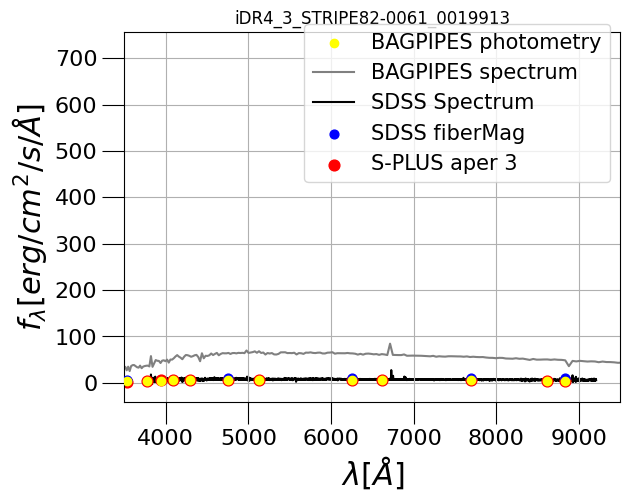


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0065_0035625.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0065_0035625.h5. To start over delete this file or change run.



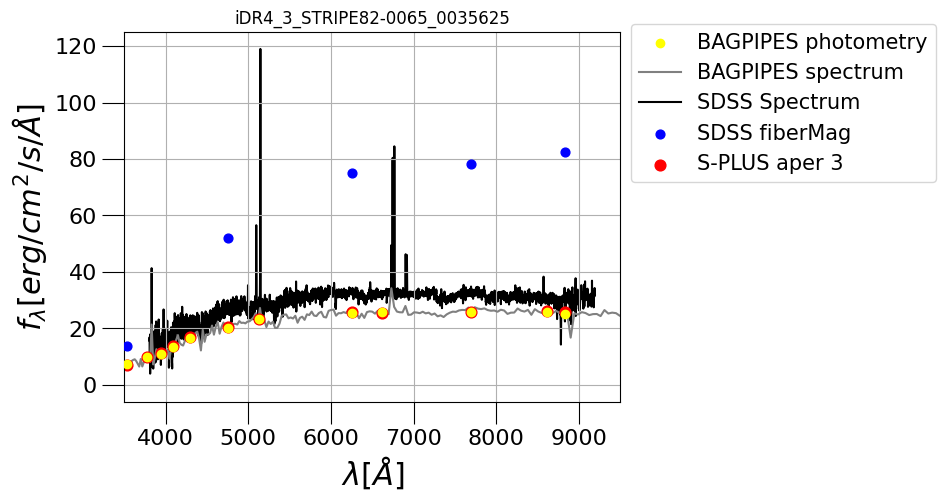


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0067_0011186.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0067_0011186.h5. To start over delete this file or change run.



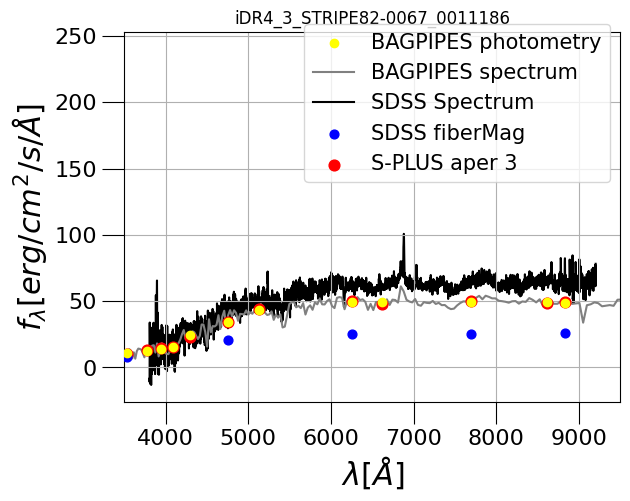


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0071_0037955.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0071_0037955.h5. To start over delete this file or change run.



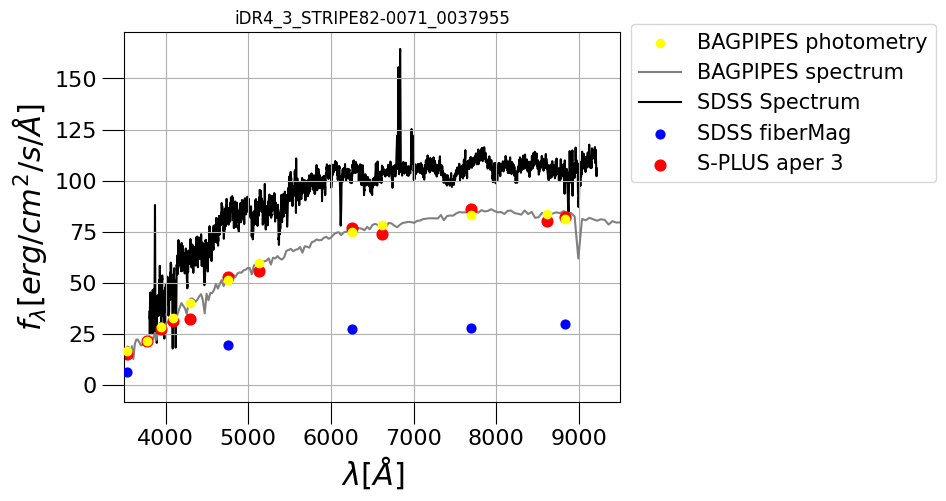


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0071_0009531.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0071_0009531.h5. To start over delete this file or change run.



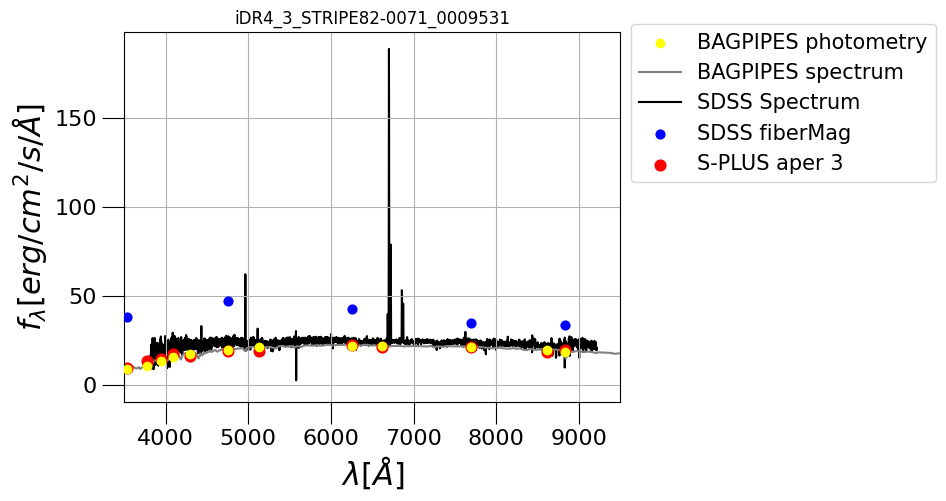


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0074_0009433.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0074_0009433.h5. To start over delete this file or change run.



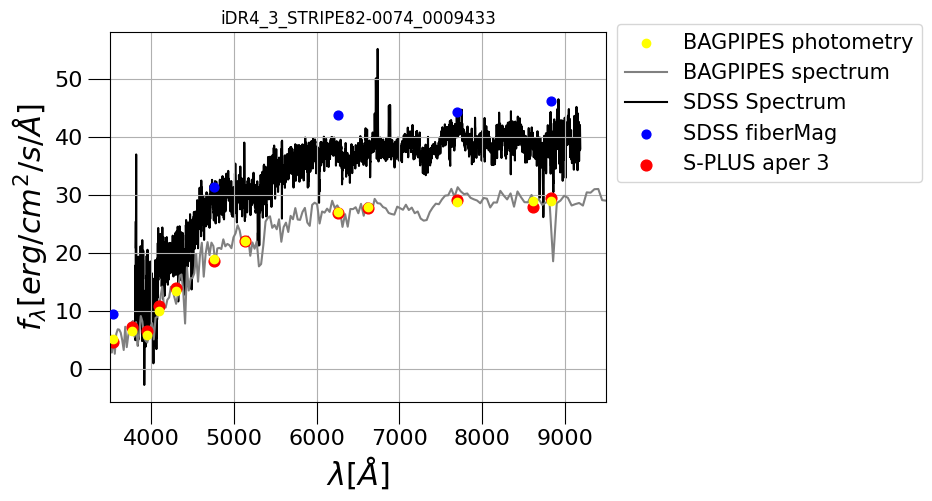


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0073_0039893.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0073_0039893.h5. To start over delete this file or change run.



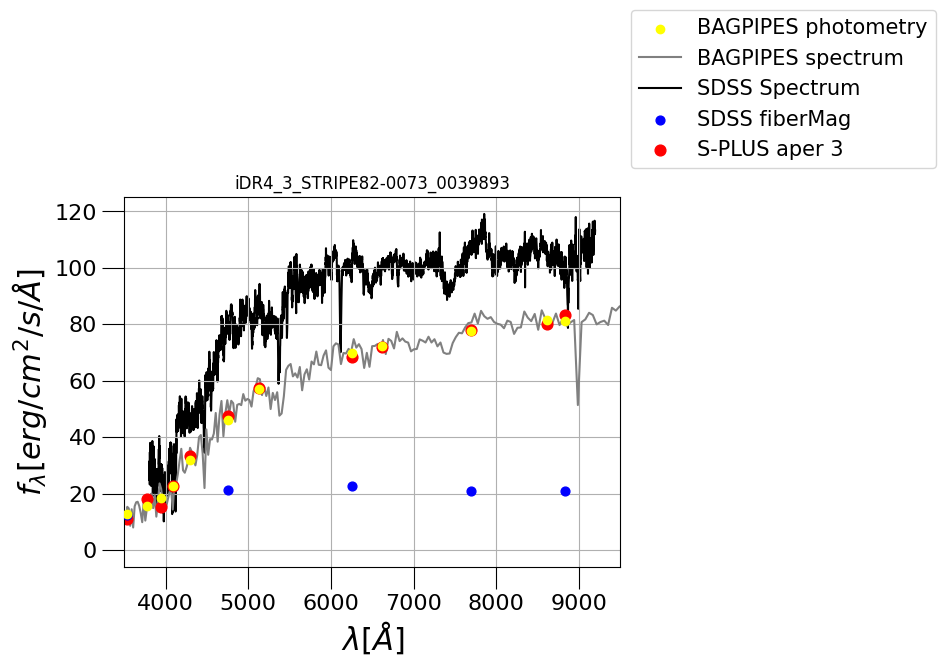


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0073_0011797.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0073_0011797.h5. To start over delete this file or change run.



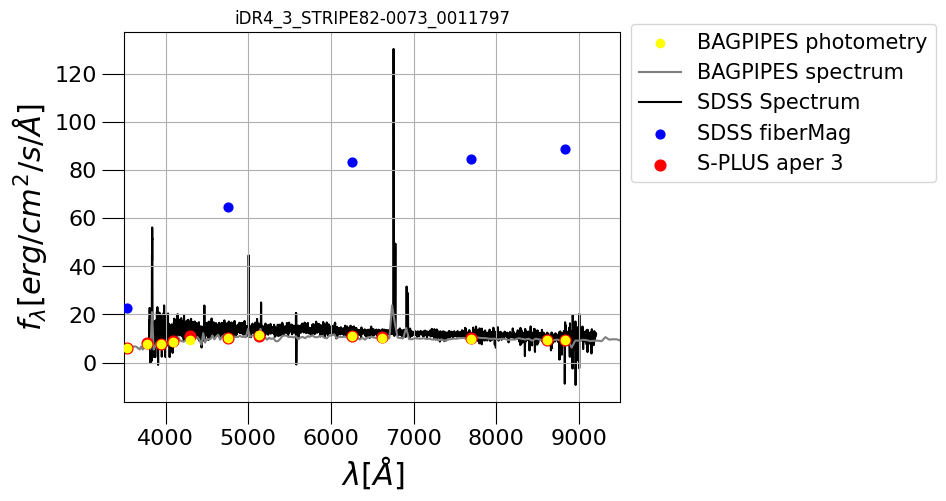


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0116_0005442.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0116_0005442.h5. To start over delete this file or change run.



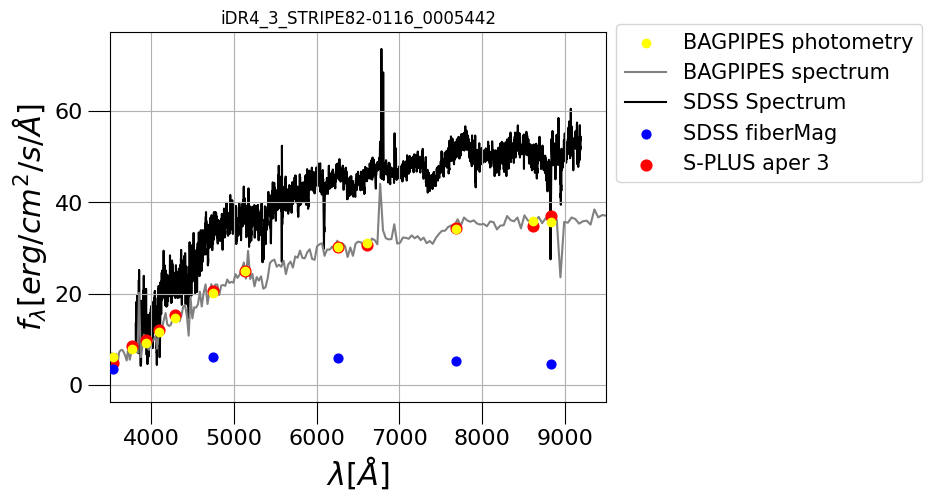

In [7]:
num=0 #CONTADOR PARA AS GALÁXIAS DA LISTA
phot_table = Table()

print(phot_table)
for f in spec:  
    
    fl_ergs_A, fl_ergs_A_err = convert(tab=tab_samp_SPLUS_aper_3, num=num, Bands=Bands, data='S-PLUS_aper_3')  

    fl_ergs_A_petro, fl_ergs_A_err_petro = convert(tab=tab_samp_SPLUS_petro, num=num, Bands=Bands, data='S-PLUS_petro')  

    fl_ergs_A_SDSS_model, fl_ergs_A_err_SDSS_model = convert(tab=tab_samp_SDSS_model, num=num, Bands=Bands_SDSS, data='SDSS')  
    
    fl_ergs_A_SDSS_fiber, fl_ergs_A_err_SDSS_fiber = convert(tab=tab_samp_SDSS_fiber, num=num, Bands=Bands_SDSS, data='SDSS')  
    
    fl_ergs_A_SDSS_fiber2, fl_ergs_A_err_SDSS_fiber2 = convert(tab=tab_samp_SDSS_fiber2, num=num, Bands=Bands_SDSS, data='SDSS')  
    
    try:
        hdul = fits.open(f)
        data = hdul[1].data  # assume the first extension is a table      
        a = f.split("-",1)
        a = a[1].split(".")
        ID = a[0]       
        
        
        galaxy = pipes.galaxy(ID, load_data_splus, spectrum_exists=False,
                            filt_list=filter_list_splus)
        fit = pipes.fit(galaxy, model_components, run="galaxies_aper3_idr4_delayed_10sources0")
        fit.fit(verbose=False)
        fit.posterior.get_advanced_quantities()

        photometry = np.asarray([(np.percentile(fit.posterior.samples['photometry'][:, k], 50)) for k in range(0,12)])
        # photometry = Table(np.asarray([(np.percentile(fit.posterior.samples['photometry'][:, k], 50)) for k in range(0,12)]))
        # phot_table = vstack([phot_table, photometry])
        # print(phot_table)
        
        mask = (fit.galaxy.photometry[:, 1] > 0.)
        upper_lims = fit.galaxy.photometry[:, 1] + fit.galaxy.photometry[:, 2]
        ymax = 1.05*np.max(upper_lims[mask])
        y_scale = int(np.log10(ymax))-2
        redshift = fit.fitted_model.model_components["redshift"]
        log_eff_wavs = np.log10(fit.galaxy.filter_set.eff_wavs)
        log_wavs = np.log10(fit.posterior.model_galaxy.wavelengths*(1.+redshift))        
        spec_post_median = np.percentile(fit.posterior.samples["spectrum_full"],
                                        (50), axis=0).T*10**-y_scale

        
        #plt.figure(figsize=(12,8))
        fig, ax = plt.subplots()
        
        #plt.ylim(0,30)
        plt.xlim(3500,9500)
        plt.title(tab_samp_SPLUS_aper_3[num]['ID'])
        ax.scatter(lamd, photometry*1e17, label='BAGPIPES photometry', zorder=4, color='yellow')
        ax.plot(10**log_wavs, spec_post_median, color="gray", zorder=2, label='BAGPIPES spectrum')
        ax.plot(10**data['loglam'],data['flux'], zorder=1, label='SDSS Spectrum', c='black')
        #ax.scatter(lamd_sdss, fl_ergs_A_SDSS_model*1e16, c='orange', s=40, zorder=3, label='SDSS modelMag')
        ax.scatter(lamd_sdss, fl_ergs_A_SDSS_fiber*1e17, c='blue', s=40, zorder=3, label='SDSS fiberMag')
        #ax.scatter(lamd_sdss, fl_ergs_A_SDSS_fiber2*1e17, c='yellow', s=40, zorder=3, label='SDSS fiber2Mag')
        ax.scatter(lamd, fl_ergs_A*1e17, c='red', s=60, zorder=2, label='S-PLUS aper 3')
        #ax.scatter(lamd, fl_ergs_A_petro*1e16, c='green', s=60, zorder=2, label='S-PLUS petro')
        plt.xlabel('$\lambda[\AA]$')
        plt.ylabel('$f_{\lambda}[erg/cm^2/s/\AA]$')
        plt.legend(bbox_to_anchor=(1,1.05))
        plt.grid()
        plt.savefig('%s.png'%(f))
        plt.show()
    except:
        pass
    
    num+=1

#phot_table.write('photometry.csv', format='csv', overwrite=True)  

# Table generation

In [20]:
num=0 #CONTADOR PARA AS GALÁXIAS DA LISTA
phot_table = Table()

for f in spec:
        a = f.split("-",1)
        a = a[1].split(".")
        ID = a[0]    
        galaxy = pipes.galaxy(ID, load_data_splus, spectrum_exists=False,
                        filt_list=filter_list_splus)
        fit = pipes.fit(galaxy, model_components, run="galaxies_aper3_idr4_delayed_10sources0")
        fit.fit(verbose=False)
        fit.posterior.get_advanced_quantities()
        print(ID)
        #id_t = Table(ID, names=('ID'), dtype=['f4'])
        photometry = Table(np.asarray([(np.percentile(fit.posterior.samples['photometry'][:, k], 50)) for k in range(0,12)]))
        #photometry = hstack((id_t, photometry))
        phot_table = vstack([phot_table, photometry])
        num+=1
print(phot_table)
phot_table.write('photometry.csv', format='csv', overwrite=True)  


Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0061_0019913.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0061_0019913.h5. To start over delete this file or change run.

iDR4_3_STRIPE82-0061_0019913

Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0065_0035625.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0065_0035625.h5. To start over delete this file or change run.

iDR4_3_STRIPE82-0065_0035625

Results loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0067_0011186.h5

Fitting not performed as results have already been loaded from pipes/posterior/galaxies_aper3_idr4_delayed_10sources0/iDR4_3_STRIPE82-0067_0011186.h5. To start over delete this file or change run.

iDR4_3_STRIPE82-0067_